In [2]:
!pip install -r requirements.txt

import math
import numpy as np
from matplotlib import pyplot as plt
import copy
#!pip install gif
import gif
from IPython.display import Image
#!pip install tqdm
from tqdm import tqdm
import time
import random

In [3]:
def animate(data, j, patch, head, joints):
    first = []
    second = []
    for i in joints:
        first.append(data[j][0][i])
        second.append(data[j][1][i])
    a = np.array([first, second])
    a = np.transpose(a)
    patch.set_xy(a)
    head.center = (data[j][0][5], data[j][1][5])
    return patch, head

# To create a gif image
@gif.frame
def plot_samples_normal(data, j):
    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(-0.1, 3))


    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor="k")
    head = plt.Circle((0, 0), radius=0.15, fc="k", ec="k")
    ax.add_patch(patch)
    ax.add_patch(head)
    plt.title(f"total_distance: {data[j][0][5]:.2f}")
    animate(data, j, patch, head, joints)
    # ax.Line2D([-0.5, 0], [10, 0], color='black')

    step_size = 11 / len(data)

    # Add a progress bar rectangle at the bottom
    progress_bar_height = 0.1
    progress_bar_y = -0.1  # Position of the progress bar on the y-axis
    progress_bar = plt.Rectangle((-1, progress_bar_y), step_size*j, progress_bar_height, color='blue')
    ax.add_patch(progress_bar)

    # Add a border for the progress bar
    progress_bar_border = plt.Rectangle((-1, progress_bar_y), 11, progress_bar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(progress_bar_border)



In [4]:
# plan is an array of 40 floating point numbers
def sim(plan):
    """
    Simulates the motion of a multi-jointed body based on a given plan.

    Parameters:
    plan (list of float): A list of control parameters for the simulation. Each element should be between -1 and 1.

    Returns:
    tuple:
        - data (list of list of list of float): A list of positions of the body parts at each time step. Each position is a list of two lists, representing the x and y coordinates of the body parts.
        - final_position (float): The final x-coordinate of the head (body part 5).

    The simulation involves:
    - Adjusting the control parameters to be within the range [-1, 1].
    - Initializing physical properties such as mass, edge lengths, spring constants, and damping factors.
    - Iteratively updating the positions and velocities of the body parts based on forces, torques, and constraints.
    - Handling contact with the ground and applying friction.
    - Recording the positions of the body parts at each time step.
    - Returning the recorded data and the final x-coordinate of the head.
    """
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1 # time step
    friction = 1.0 # friction coefficient
    gravity = 0.1 # gravity constant
    mass = [30, 10, 5, 10, 5, 10] # mass of body parts
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9] # edge lengths
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]    # spring constants
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]   # damping factors
    anglessp = [20.0, 20.0, 10.0, 10.0] # angular spring constants
    anglesf = [8.0, 8.0, 4.0, 4.0]  # angular damping factors

    edge = [(0, 1), (1, 2), (0, 3), (3, 4), (0, 5)] # edges
    angles = [(4, 0), (4, 2), (0, 1), (2, 3)] # angles

    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    p = [[0, 0, -0.25, 0.25, 0.25, 0.15], [1, 0.5, 0, 0.5, 0, 1.9]]

    spin = 0.0
    maxspin = 0.0
    lastang = 0.0

    data = []

    for j in range(20): # 20 time steps
        for k in range(10): # 10 substeps
            lamb = 0.05 + 0.1 * k
            t0 = 0.5
            if j > 0:
                t0 = plan[2 * j - 2]
            t0 *= 1 - lamb
            t0 += plan[2 * j] * lamb

            t1 = 0.0
            if j > 0:
                t1 = plan[2 * j - 1]
            t1 *= 1 - lamb
            t1 += plan[2 * j + 1] * lamb

            contact = [False, False, False, False, False, False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8 + t0), -(2.8 - t0), -(1 - t1) * 0.9, -(1 + t1) * 0.9]

            disp = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            dist = [0, 0, 0, 0, 0]
            dispn = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]] - p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]] - p[1][edge[z][0]]
                dist[z] = (
                    math.sqrt(disp[0][z] * disp[0][z] + disp[1][z] * disp[1][z]) + 0.01
                )
                inv = 1.0 / dist[z]
                dispn[0][z] = disp[0][z] * inv
                dispn[1][z] = disp[1][z] * inv

            dispv = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            distv = [0, 0, 0, 0, 0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2 * (disp[0][z] * dispv[0][z] + disp[1][z] * dispv[1][z])

            forceedge = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                c = (edgel[z] - dist[z]) * edgesp[z] - distv[z] * edgef[z]
                forceedge[0][z] = c * dispn[0][z]
                forceedge[1][z] = c * dispn[1][z]

            edgeang = [0, 0, 0, 0, 0]
            edgeangv = [0, 0, 0, 0, 0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z] * disp[1][z] - dispv[1][z] * disp[0][z]) / (
                    dist[z] * dist[z]
                )

            inc = edgeang[4] - lastang
            if inc < -math.pi:
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - 0.005 * (k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0, 0, 0, 0]
            for z in range(4):
                angv[z] = edgeangv[angles[z][1]] - edgeangv[angles[z][0]]

            angf = [0, 0, 0, 0]
            for z in range(4):
                ang = edgeang[angles[z][1]] - edgeang[angles[z][0]] - anglesl[z]
                if ang > math.pi:
                    ang -= 2 * math.pi
                elif ang < -math.pi:
                    ang += 2 * math.pi
                m0 = dist[angles[z][0]] / edgel[angles[z][0]]
                m1 = dist[angles[z][1]] / edgel[angles[z][1]]
                angf[z] = ang * anglessp[z] - angv[z] * anglesf[z] * min(m0, m1)

            edgetorque = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                inv = 1.0 / (dist[z] * dist[z])
                edgetorque[0][z] = -disp[1][z] * inv
                edgetorque[1][z] = disp[0][z] * inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z] * edgetorque[0][i0]
                forceedge[1][i0] += angf[z] * edgetorque[1][i0]
                forceedge[0][i1] -= angf[z] * edgetorque[0][i1]
                forceedge[1][i1] -= angf[z] * edgetorque[1][i1]

            f = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity * mass[z]
                invm = 1.0 / mass[z]
                v[0][z] += f[0][z] * dt * invm
                v[1][z] += f[1][z] * dt * invm

                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z] * s < fric * friction:
                        v[0][z] = 0
                    else:
                        v[0][z] -= fric * friction * s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt

            data.append(copy.deepcopy(p))

            if contact[0] or contact[5]:
                return data, p[0][5]
    return data, p[0][5]

In [5]:
# TODO: Design an optimization algorithm to find the optimal plan
#plan = [np.random.uniform(-1, 1) for i in range(40)]

In [6]:
def mcmc_optimization(sim, initial_plan=None, max_iter=10, step_size=0.1, initial_temp=1.0, cooling_rate=0.99, milestones=None):
    if initial_plan is None:
        plan = np.random.uniform(-1, 1, 40)
    else:
        plan = np.array(initial_plan)

    best_plan = plan.copy()
    best_distance = sim(plan)[1]
    temperature = initial_temp  # Initialize temperature

    milestone_plans = {}
    if milestones is None:
        milestones = []

    milestones = sorted([m for m in milestones if m < max_iter])
    milestone_index = 0
    total_milestones = len(milestones)

    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iter), desc="Running MCMC Optimization"):
        new_plan = plan + np.random.uniform(-step_size, step_size, size=40)
        new_plan = np.clip(new_plan, -1, 1)  # Keep within bounds

        _, current_distance = sim(plan)
        _, new_distance = sim(new_plan)

        if new_distance > current_distance or np.random.rand() < np.exp((new_distance - current_distance) / temperature):
            plan = new_plan.copy()

        if new_distance > best_distance:
            best_plan = new_plan.copy()
            best_distance = new_distance

        temperature *= cooling_rate

        if milestone_index < total_milestones and i == milestones[milestone_index]:
            milestone_plans[milestones[milestone_index]] = best_plan.copy()
            tqdm.write(f"Milestone {milestones[milestone_index]} iterations reached. Best distance: {best_distance:.2f}")
            milestone_index += 1

    elapsed_time = time.time() - start_time
    print(f"\nMCMC completed in {elapsed_time:.2f} seconds.")

    return best_plan, best_distance, milestone_plans

In [7]:
# Define milestones
#milestones = [1000, 10000, 100000]
milestones = [1, 10, 15]

initial_plan = [np.random.uniform(-1, 1) for _ in range(40)]

# Run MCMC Optimization
mcmc_plan, mcmc_distance, milestone_plans = mcmc_optimization(
    sim,
    initial_plan=initial_plan,
    max_iter=milestones[-1] + 1,  
    milestones=milestones
)
print("MCMC Optimization:")
print("Best Distance Achieved:", mcmc_distance)
print("Best Plan:", mcmc_plan)

Running MCMC Optimization:  31%|█████████                    | 5/16 [00:00<00:00, 20.60it/s]

Milestone 1 iterations reached. Best distance: 0.16


Running MCMC Optimization:  88%|████████████████████████▌   | 14/16 [00:00<00:00, 20.84it/s]

Milestone 10 iterations reached. Best distance: 0.16


Running MCMC Optimization: 100%|████████████████████████████| 16/16 [00:00<00:00, 20.97it/s]

Milestone 15 iterations reached. Best distance: 0.16

MCMC completed in 0.81 seconds.
MCMC Optimization:
Best Distance Achieved: 0.15501920242051787
Best Plan: [-0.02337757 -0.71688291  0.58148625  0.47998133 -0.83521186 -0.36439395
 -0.61737175 -0.02927144  0.06129183  0.42425517 -0.46686939  0.08572463
 -0.44909872  0.81706945  0.09377403  0.41143199  0.63142213 -0.15262146
  0.93473312  0.63475085 -0.08759734 -0.37159176  0.61759362 -0.842869
 -0.69776285  0.82081551  0.32707743  0.20282981  0.08963227  0.48781931
  0.26789736  0.48672152 -0.02621173 -0.25210207  0.13321127  0.16753245
 -0.65183389 -0.75460002 -0.1345478  -0.88944073]


Simulating plan at milestone 1 iterations...
Total Distance at milestone 1: 0.16
GIF saved as mcmc_animation_1.gif


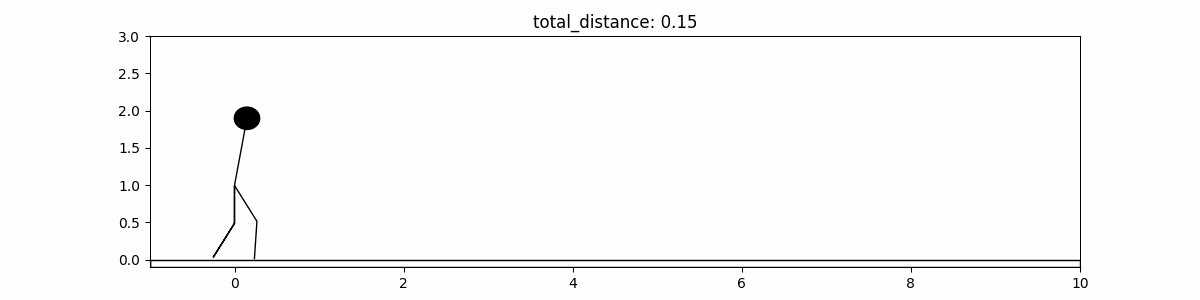

Simulating plan at milestone 10 iterations...
Total Distance at milestone 10: 0.16
GIF saved as mcmc_animation_10.gif


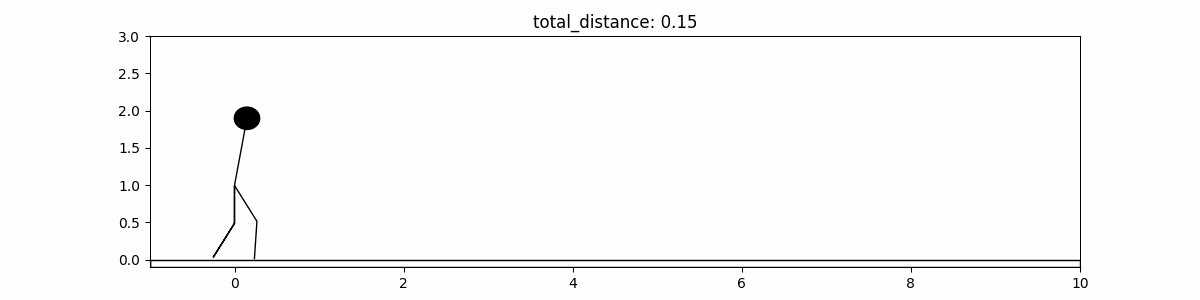

Simulating plan at milestone 15 iterations...
Total Distance at milestone 15: 0.16
GIF saved as mcmc_animation_15.gif


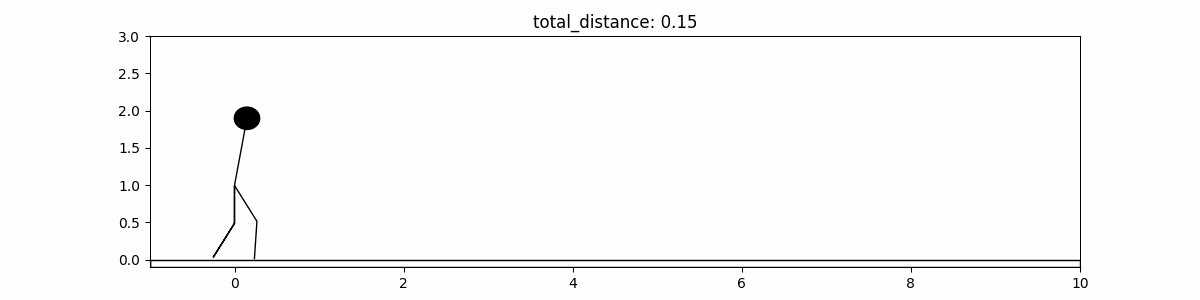

In [8]:
# Function to create and save GIFs for milestone plans
def create_gifs_for_milestones(sim, milestone_plans, filename_prefix="mcmc_animation"):
    for milestone, plan in milestone_plans.items():
        print(f"Simulating plan at milestone {milestone} iterations...")
        data, total_distance = sim(plan)
        print(f"Total Distance at milestone {milestone}: {total_distance:.2f}")

        # Create frames
        frames = []
        for j in range(len(data)):
            frame = plot_samples_normal(data, j)
            frames.append(frame)

        # Define filename based on milestone
        filename = f"{filename_prefix}_{milestone}.gif"

        # Save GIF
        gif.save(frames, filename, duration=40)
        print(f"GIF saved as {filename}")

        # Display the GIF
        display(Image(filename=filename))


# Create and save GIFs for each milestone
create_gifs_for_milestones(sim, milestone_plans)

In [9]:
#data, total_distance = sim(mcmc_plan)
#print("Total Distance = ", total_distance)

In [10]:
# Create a gif
#frames = []
#for j in range(len(data)):
#    frame = plot_samples_normal(data, j)
#    frames.append(frame)

#gif.save(frames, "mcmc_animation.gif", duration=40)
#Image(filename="mcmc_animation.gif")

In [11]:
def gradient_based_optimization(
    sim, initial_plan=None, max_iter=10, initial_learning_rate=0.1, epsilon=1e-5, milestones=None
):
    if initial_plan is None:
        plan = np.random.uniform(-1, 1, 40)
    else:
        plan = np.array(initial_plan)

    best_plan = plan.copy()
    best_distance = sim(plan)[1]
    velocity = np.zeros_like(plan)

    milestone_plans = {}
    if milestones is None:
        milestones = []

    milestones = sorted([m for m in milestones if m < max_iter])
    milestone_index = 0
    total_milestones = len(milestones)

    start_time = time.time()  # Start timing

    for t in tqdm(range(1, max_iter + 1), desc="Running Gradient-Based Optimization"):
        gradient = np.zeros_like(plan)
        for i in range(len(plan)):
            # Finite difference approximation
            perturbed_plan = plan.copy()
            perturbed_plan[i] += epsilon
            _, f_x1 = sim(perturbed_plan)
            _, f_x0 = sim(plan)
            gradient[i] = (f_x1 - f_x0) / epsilon

        gradient = np.clip(gradient, -1, 1)

        learning_rate = initial_learning_rate / (1 + 0.01 * t)

        plan += learning_rate * gradient
        plan = np.clip(plan, -1, 1)  # Keep within bounds

        # Evaluate the updated plan
        _, current_distance = sim(plan)
        if current_distance > best_distance:
            best_plan = plan.copy()
            best_distance = current_distance

        # Check if the current iteration is a milestone
        if milestone_index < total_milestones and t == milestones[milestone_index]:
            milestone_plans[milestones[milestone_index]] = best_plan.copy()
            tqdm.write(f"Milestone {milestones[milestone_index]} iterations reached. Best distance: {best_distance:.2f}")
            milestone_index += 1

    elapsed_time = time.time() - start_time
    print(f"\nGradient-Based Optimization completed in {elapsed_time:.2f} seconds.")

    return best_plan, best_distance, milestone_plans

In [12]:
# Define milestones
#milestones = [1000, 10000, 100000]
milestones = [1, 10, 15]

initial_plan = [np.random.uniform(-1, 1) for _ in range(40)]

# Run Gradient-Based Optimization with milestones
gbo_plan, gbo_distance, milestone_plans = gradient_based_optimization(
    sim,
    initial_plan=initial_plan,
    max_iter=milestones[-1] + 1,  # Ensure max_iter covers all milestones
    milestones=milestones,
)
print("\nGradient-Based Optimization:")
print("Best Distance Achieved:", gbo_distance)
print("Best Plan:", gbo_plan)

Running Gradient-Based Optimization:   6%|█▏                 | 1/16 [00:00<00:14,  1.01it/s]

Milestone 1 iterations reached. Best distance: -0.42


Running Gradient-Based Optimization:  62%|███████████▎      | 10/16 [00:09<00:04,  1.23it/s]

Milestone 10 iterations reached. Best distance: -0.05


Running Gradient-Based Optimization:  94%|████████████████▉ | 15/16 [00:13<00:00,  1.11it/s]

Milestone 15 iterations reached. Best distance: 0.09


Running Gradient-Based Optimization: 100%|██████████████████| 16/16 [00:14<00:00,  1.14it/s]


Gradient-Based Optimization completed in 14.05 seconds.

Gradient-Based Optimization:
Best Distance Achieved: 0.09277992592970372
Best Plan: [ 1.         -0.34371071 -0.09488265  0.44658478 -0.95083632 -0.36338872
 -1.         -0.26665597  0.52464983  0.4145843   0.15483325 -0.9205011
  0.96631806 -0.21924534 -0.49427021 -0.83247215 -0.87935193  0.09290744
 -0.09752574 -0.45682274 -0.50984472  0.9822021  -0.00923177  0.89944343
  0.50336524 -0.36686371  0.90713584  0.69942129 -0.8458255  -0.97139137
  0.01291182  0.51288905  0.88348083 -0.54217167 -0.57788207  0.9849109
  0.72695214 -0.28209233  0.95406044 -0.34156305]


Simulating plan at milestone 1 iterations...
Total Distance at milestone 1: -0.42
GIF saved as gbo_animation_1.gif


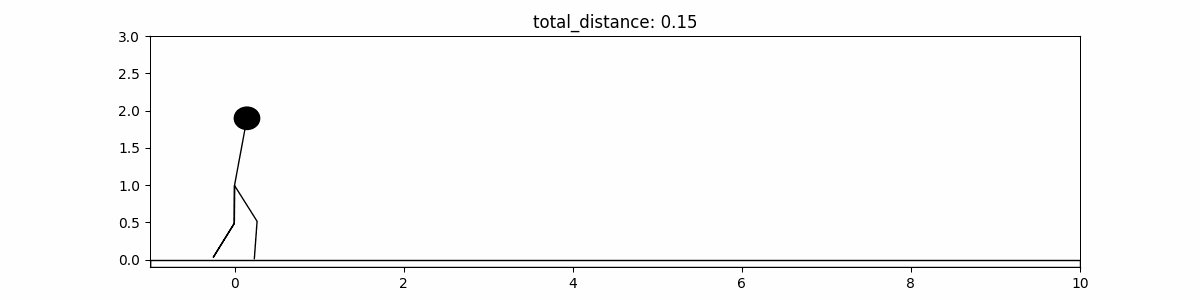

Simulating plan at milestone 10 iterations...
Total Distance at milestone 10: -0.05
GIF saved as gbo_animation_10.gif


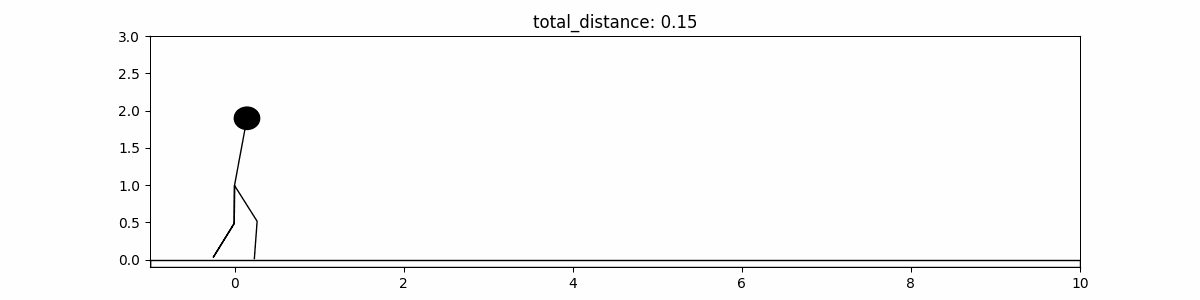

Simulating plan at milestone 15 iterations...
Total Distance at milestone 15: 0.09
GIF saved as gbo_animation_15.gif


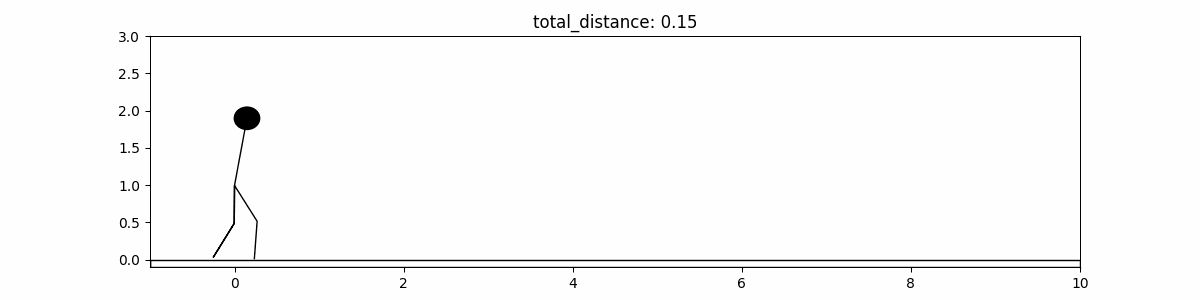

In [13]:
# Function to create and save GIFs for milestone plans
def create_gifs_for_milestones(sim, milestone_plans, filename_prefix="gbo_animation"):
    for milestone, plan in milestone_plans.items():
        print(f"Simulating plan at milestone {milestone} iterations...")
        data, total_distance = sim(plan)
        print(f"Total Distance at milestone {milestone}: {total_distance:.2f}")

        # Create frames
        frames = []
        for j in range(len(data)):
            frame = plot_samples_normal(data, j)
            frames.append(frame)

        # Define filename based on milestone
        filename = f"{filename_prefix}_{milestone}.gif"

        # Save GIF
        gif.save(frames, filename, duration=40)
        print(f"GIF saved as {filename}")

        # Display the GIF
        display(Image(filename=filename))


# Create and save GIFs for each milestone
create_gifs_for_milestones(sim, milestone_plans)

In [14]:
#data, total_distance = sim(gbo_plan)
#print("Total Distance = ", total_distance)

In [15]:
# Create a gif
#frames = []
#for j in range(len(data)):
#    frame = plot_samples_normal(data, j)
#    frames.append(frame)

#gif.save(frames, "gbo_animation.gif", duration=40)
#Image(filename="gbo_animation.gif")

In [16]:
def evolutionary_algorithm(
    sim, population_size=50, generations=10, mutation_rate=0.1, crossover_rate=0.8, milestones=None
):
    # Initialize the population with random plans
    population = [np.random.uniform(-1, 1, 40) for _ in range(population_size)]

    # Function to evaluate fitness of each individual
    def evaluate_fitness(individual):
        _, distance = sim(individual)
        return distance

    # Initialize milestone tracking
    milestone_plans = {}
    if milestones is None:
        milestones = []

    milestones = sorted([m for m in milestones if m < generations])
    milestone_index = 0
    total_milestones = len(milestones)

    start_time = time.time()  # Start timing

    # Evolutionary loop
    for generation in tqdm(range(generations), desc="Running Evolutionary Algorithm"):
        # Evaluate the fitness of the population
        fitness = np.array([evaluate_fitness(ind) for ind in population])

        # Track the best individual
        best_index = np.argmax(fitness)
        best_individual = population[best_index]
        best_fitness = fitness[best_index]

        tqdm.write(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        if milestone_index < total_milestones and generation == milestones[milestone_index]:
            milestone_plans[milestones[milestone_index]] = best_individual.copy()
            tqdm.write(f"Milestone {milestones[milestone_index]} generations reached. Best distance: {best_fitness:.2f}")
            milestone_index += 1

        # Selection: Use tournament selection
        selected_parents = []
        for _ in range(population_size):
            candidates = random.sample(population, 3)  # Randomly pick 3 individuals
            parent = max(candidates, key=evaluate_fitness)
            selected_parents.append(parent)

        next_population = []
        for _ in range(population_size // 2):
            if np.random.rand() < crossover_rate:
                # Select two parents
                parent1, parent2 = random.sample(selected_parents, 2)
                # Single-point crossover
                crossover_point = np.random.randint(1, len(parent1) - 1)
                child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
                child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            else:
                # No crossover, just copy parents
                child1, child2 = parent1, parent2

            next_population.extend([child1, child2])

        # Mutation: Introduce random changes
        for individual in next_population:
            if np.random.rand() < mutation_rate:
                mutation_point = np.random.randint(0, len(individual))
                individual[mutation_point] += np.random.normal(0, 0.1)  # Add small noise
                individual = np.clip(individual, -1, 1)  # Ensure within bounds

        # Replace the old population with the new one
        population = next_population

    elapsed_time = time.time() - start_time
    print(f"\nEvolutionary Algorithm completed in {elapsed_time:.2f} seconds.")

    # Return the best solution found and the milestone plans
    return best_individual, best_fitness, milestone_plans

In [17]:
# Define milestones
#milestones = [100, 1000, 10000]  # Specify the generations for milestones
milestones = [1, 10, 15]

# Run Evolutionary Algorithm with milestones
best_plan, best_fitness, milestone_plans = evolutionary_algorithm(
    sim, population_size=50, generations=milestones[-1] + 1, milestones=milestones
)
print(f"Best Plan Found: {best_plan}")
print(f"Best Fitness: {best_fitness}")

Running Evolutionary Algorithm:   0%|                                | 0/16 [00:00<?, ?it/s]

Generation 0: Best Fitness = 1.31


Running Evolutionary Algorithm:   6%|█▌                      | 1/16 [00:03<00:41,  2.78s/it]

Generation 1: Best Fitness = 0.98
Milestone 1 generations reached. Best distance: 0.98


Running Evolutionary Algorithm:  12%|███                     | 2/16 [00:06<00:37,  2.69s/it]

Generation 2: Best Fitness = 1.84


Running Evolutionary Algorithm:  19%|████▌                   | 3/16 [00:08<00:34,  2.63s/it]

Generation 3: Best Fitness = 0.97


Running Evolutionary Algorithm:  25%|██████                  | 4/16 [00:11<00:31,  2.63s/it]

Generation 4: Best Fitness = 1.92


Running Evolutionary Algorithm:  31%|███████▌                | 5/16 [00:13<00:27,  2.46s/it]

Generation 5: Best Fitness = 1.93


Running Evolutionary Algorithm:  38%|█████████               | 6/16 [00:16<00:25,  2.50s/it]

Generation 6: Best Fitness = 2.27


Running Evolutionary Algorithm:  44%|██████████▌             | 7/16 [00:19<00:24,  2.70s/it]

Generation 7: Best Fitness = 3.37


Running Evolutionary Algorithm:  50%|████████████            | 8/16 [00:23<00:26,  3.26s/it]

Generation 8: Best Fitness = 2.42


Running Evolutionary Algorithm:  56%|█████████████▌          | 9/16 [00:28<00:24,  3.54s/it]

Generation 9: Best Fitness = 2.42


Running Evolutionary Algorithm:  62%|██████████████▍        | 10/16 [00:32<00:22,  3.77s/it]

Generation 10: Best Fitness = 2.42
Milestone 10 generations reached. Best distance: 2.42


Running Evolutionary Algorithm:  69%|███████████████▊       | 11/16 [00:37<00:20,  4.16s/it]

Generation 11: Best Fitness = 2.42


Running Evolutionary Algorithm:  75%|█████████████████▎     | 12/16 [00:42<00:17,  4.45s/it]

Generation 12: Best Fitness = 2.42


Running Evolutionary Algorithm:  81%|██████████████████▋    | 13/16 [00:47<00:13,  4.41s/it]

Generation 13: Best Fitness = 2.42


Running Evolutionary Algorithm:  88%|████████████████████▏  | 14/16 [00:52<00:09,  4.66s/it]

Generation 14: Best Fitness = 2.45


Running Evolutionary Algorithm:  94%|█████████████████████▌ | 15/16 [00:57<00:04,  4.76s/it]

Generation 15: Best Fitness = 2.50
Milestone 15 generations reached. Best distance: 2.50


Running Evolutionary Algorithm: 100%|███████████████████████| 16/16 [01:00<00:00,  3.80s/it]


Evolutionary Algorithm completed in 60.76 seconds.
Best Plan Found: [-0.63720926 -0.00585903 -0.34447919 -0.75383606  0.92256815 -0.47141094
 -0.59154482 -0.31942608 -0.97221625 -0.6188363   0.4484335  -0.60033376
 -0.44769622  0.35580558  0.30269167 -0.72750588  0.51021508  0.82139536
  0.63400191 -0.39330371 -0.46446437  0.526647    0.25269131  0.36756057
 -0.647701    0.97789716 -0.24856325 -0.61510328  0.49980229  0.91839554
 -0.71269251 -0.1088932  -0.32407788 -0.01905001  0.80442893  0.7674517
  0.921212    0.91225712  0.99719777  0.22488501]
Best Fitness: 2.495918657825301


Simulating plan at milestone 1 generations...
Total Distance at milestone 1: 0.98
GIF saved as evol_animation_1.gif


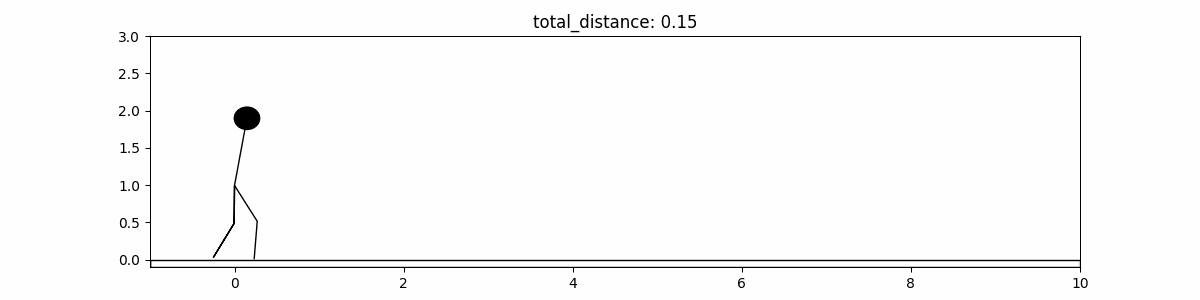

Simulating plan at milestone 10 generations...
Total Distance at milestone 10: 2.42
GIF saved as evol_animation_10.gif


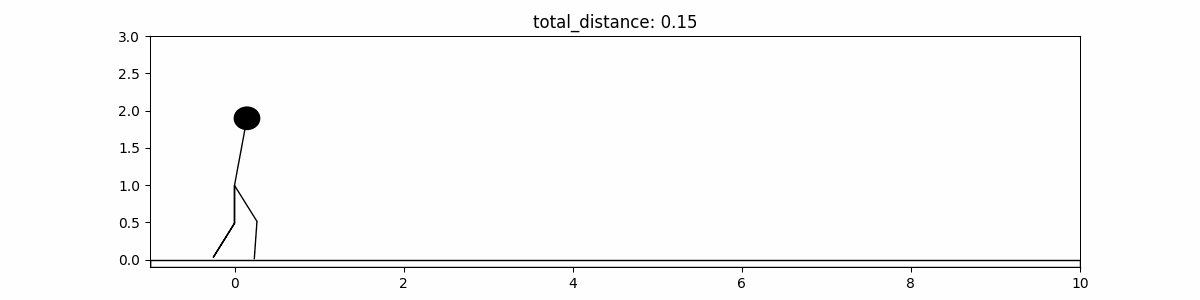

Simulating plan at milestone 15 generations...
Total Distance at milestone 15: 2.50


In [ ]:
def create_gifs_for_milestones(sim, milestone_plans, filename_prefix="evol_animation"):
    for milestone, plan in milestone_plans.items():
        print(f"Simulating plan at milestone {milestone} generations...")
        data, total_distance = sim(plan)
        print(f"Total Distance at milestone {milestone}: {total_distance:.2f}")

        frames = []
        for j in range(len(data)):
            frame = plot_samples_normal(data, j)
            frames.append(frame)

        filename = f"{filename_prefix}_{milestone}.gif"

        gif.save(frames, filename, duration=40)
        print(f"GIF saved as {filename}")

        display(Image(filename=filename))


create_gifs_for_milestones(sim, milestone_plans)

In [ ]:
#data, total_distance = sim(best_plan)
#print("Total Distance = ", total_distance)

In [ ]:
# Create a gif
#frames = []
#for j in range(len(data)):
#    frame = plot_samples_normal(data, j)
#    frames.append(frame)

#gif.save(frames, "evol_animation.gif", duration=40)
#Image(filename="evol_animation.gif")

In [ ]:
###########
# The following code is given as an example to store a video of the run and to display
# the run in a graphics window. You will treat sim(plan) as a black box objective
# function and maximize it.
###########

#data, total_distance = sim(plan)
#print("Total Distance = ", total_distance)